In [1]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [2]:
# Load the .mat file
data = scipy.io.loadmat("B0005.mat")
battery = data['B0005'][0][0]
cycles = battery['cycle'][0]

cycle_nums = []
capacities = []

for i, cycle in enumerate(cycles):
    if cycle['type'][0] == 'charge':
        d = cycle['data'][0, 0]
        current = d['Current_charge'][0]
        time = d['Time'][0]
        
        try:
            time = [float(t) for t in time]
        except:
            time = time.astype(float)
        
        delta_t = np.diff(time)
        current_avg = (current[1:] + current[:-1]) / 2
        capacity = np.sum(current_avg * delta_t) / 3600  # Convert to Ah
        
        cycle_nums.append(i + 1)
        capacities.append(capacity)

df = pd.DataFrame({
    'Cycle': cycle_nums,
    'Capacity (Ah)': capacities
})

# Compute SOH
initial_capacity = df['Capacity (Ah)'][:5].max()
df['SOH (%)'] = (df['Capacity (Ah)'] / initial_capacity) * 100

df.head()


,Cycle,Capacity (Ah),SOH (%)
0,1,0.770778,41.322550
1,3,1.865272,100.000000
2,5,1.858042,99.612425
3,7,1.850149,99.189259
4,9,1.848153,99.082267


In [3]:
# Define sequence creation function
def create_sequences_transformer(data, seq_len=5):
    X = []
    y = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        target = data[i+seq_len]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# Use SOH (%) values
soh_values = df['SOH (%)'].values

# Create sequences
SEQ_LEN = 5
X, y = create_sequences_transformer(soh_values, SEQ_LEN)

print("Input shape:", X.shape)  # e.g., (samples, seq_len)
print("Target shape:", y.shape)  # e.g., (samples,)


Input shape: (165, 5)
Target shape: (165,)


In [4]:
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Normalize SOH values
scaler = MinMaxScaler()
soh_norm = scaler.fit_transform(soh_values.reshape(-1, 1)).flatten()

# Recreate sequences using normalized SOH
X_norm, y_norm = create_sequences_transformer(soh_norm, SEQ_LEN)

# Convert to tensors and reshape for Transformer: (batch, seq_len, 1)
X_tensor = torch.tensor(X_norm, dtype=torch.float32).unsqueeze(2)  # (N, seq_len, 1)
y_tensor = torch.tensor(y_norm, dtype=torch.float32).unsqueeze(1)  # (N, 1)

# Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print("X_tensor shape:", X_tensor.shape)
print("y_tensor shape:", y_tensor.shape)


X_tensor shape: torch.Size([165, 5, 1])
y_tensor shape: torch.Size([165, 1])


In [5]:
import torch.nn as nn

class TransformerSOHPredictor(nn.Module):
    def __init__(self, input_dim=1, seq_len=5, model_dim=64, num_heads=4, num_layers=2):
        super(TransformerSOHPredictor, self).__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)  # project input to model_dim
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=128,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len * model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer_encoder(x)
        out = self.regressor(x)
        return out


In [6]:
model = TransformerSOHPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)


TransformerSOHPredictor(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (regressor): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias

In [7]:
# Move data and model to appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

# Training loop
epochs = 100
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor).squeeze()
    loss = criterion(output, y_tensor.squeeze())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/100], Loss: 0.0176
Epoch [20/100], Loss: 0.0314
Epoch [30/100], Loss: 0.0157
Epoch [40/100], Loss: 0.0149
Epoch [50/100], Loss: 0.0131
Epoch [60/100], Loss: 0.0106
Epoch [70/100], Loss: 0.0092
Epoch [80/100], Loss: 0.0110
Epoch [90/100], Loss: 0.0098
Epoch [100/100], Loss: 0.0094


In [8]:
# Calculate min and max for SOH normalization (if not already done)
soh_min = y_tensor.min().item()
soh_max = y_tensor.max().item()

# Normalize again (in case y_tensor was created directly from unnormalized y)
y_tensor = (y_tensor - soh_min) / (soh_max - soh_min)


In [9]:
# Evaluation
model.eval()
with torch.no_grad():
    predicted = model(X_tensor).squeeze().cpu().numpy()
    actual = y_tensor.squeeze().cpu().numpy()

# Denormalize
predicted_soh = predicted * (soh_max - soh_min) + soh_min
actual_soh = actual * (soh_max - soh_min) + soh_min


In [14]:
# Define threshold for End of Life (EOL)
soh_threshold = 0.8 * (soh_max - soh_min) + soh_min  # 80% of original capacity

# Calculate RUL: for each time step, count how many steps until SOH drops below threshold
rul = []
for i in range(len(predicted_soh)):
    remaining = 0
    for j in range(i, len(predicted_soh)):
        if predicted_soh[j] >= soh_threshold:
            remaining += 1
        else:
            break
    rul.append(remaining)

# Create a DataFrame to compare
import pandas as pd

results_df = pd.DataFrame({
    'Cycle': df['Cycle'].iloc[-len(predicted_soh):].values,
    'Capacity (Ah)': df['Capacity (Ah)'].iloc[-len(predicted_soh):].values,
    'SOH (%)': actual_soh*100,
    'Predicted SOH (%)': predicted_soh*100,
    'Predicted RUL (cycles)': rul
})

results_df.head()


,Cycle,Capacity (Ah),SOH (%),Predicted SOH (%),Predicted RUL (cycles)
0,11,1.848912,99.122925,97.215584,98
1,13,1.847459,99.045036,98.512779,97
2,15,1.848649,99.108849,98.369507,96
3,17,1.837080,98.488586,98.303635,95
4,19,1.837181,98.494034,98.184624,94


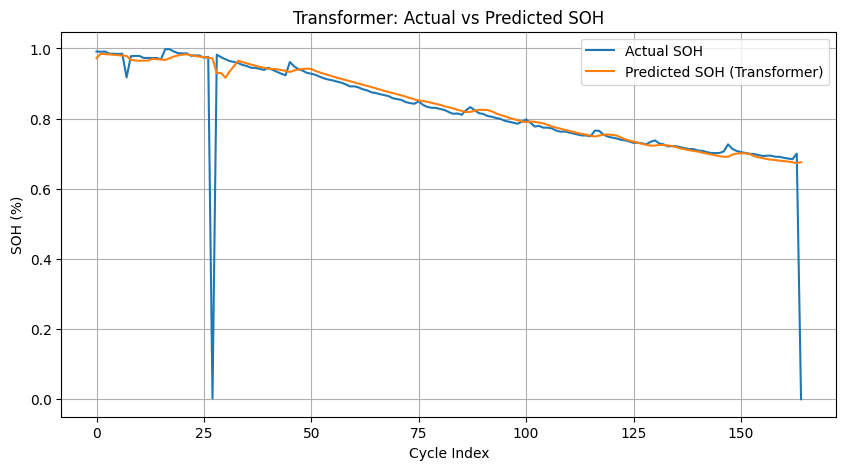

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actual_soh, label='Actual SOH')
plt.plot(predicted_soh, label='Predicted SOH (Transformer)')
plt.xlabel('Cycle Index')
plt.ylabel('SOH (%)')
plt.title('Transformer: Actual vs Predicted SOH')
plt.legend()
plt.grid(True)
plt.show()


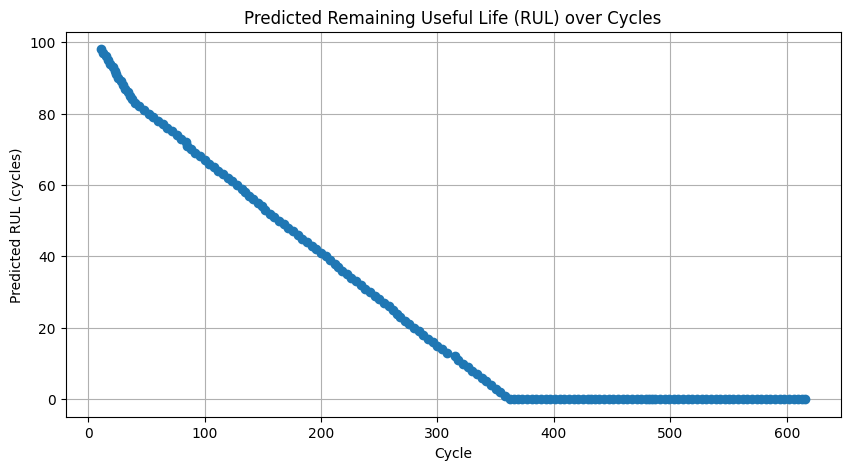

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_df['Cycle'], results_df['Predicted RUL (cycles)'], marker='o', linestyle='-')
plt.xlabel("Cycle")
plt.ylabel("Predicted RUL (cycles)")
plt.title("Predicted Remaining Useful Life (RUL) over Cycles")
plt.grid(True)
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(actual_soh, predicted_soh)
rmse = np.sqrt(mean_squared_error(actual_soh, predicted_soh))
r2 = r2_score(actual_soh, predicted_soh)

print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"R² Score (Closer to 1 is better): {r2:.4f}")


MAE  (Mean Absolute Error): 0.0199
RMSE (Root Mean Square Error): 0.0930
R² Score (Closer to 1 is better): 0.5401
